## 运行环境
python 3.6.3

Anaconda custom (64-bit)

win10

In [1]:
# _*_ coding:utf-8 _*_
import numpy as np # 矩阵运算
import matplotlib.pyplot as plt # 

## 任务定义

通过**线性回归**预测**波斯顿房价**

## 方法描述 - 梯度下降

使用**梯度下降法**进行参数学习

$$
损失函数: \ Lost_i = \frac 1 2 (y^{\{i\}}_p - y^{\{i\}}_r)^2
$$

* $y^{\{i\}}_p$ : 对于第i个样本的预测值(predict), $y^{\{i\}}_p = X_i \times w + b$, 右乘$w$
* $y^{\{i\}}_r$ : 第i个样本的真实值(real)


$$
代价函数: \ Cost = \frac 1 m \sum^{m}_{i=1}{Lost_i}
$$

* m : 训练样本的数量

### 梯度计算

#### b
$\frac {\partial y^{\{i\}}_p}{\partial b} = 1$

$$
\frac {\partial C}{\partial b} = 
\frac 1 m \sum^{m}_{i=1}{\frac {\partial{L_i}}{\partial b}} =  
\frac 1 m \sum^{m}_{i=1} [{(y^{\{i\}}_p - y^{\{i\}}_r)} \frac {\partial y^{\{i\}}_p}{\partial b}] =
\frac 1 m \sum^{m}_{i=1}{(y^{\{i\}}_p - y^{\{i\}}_r)} 
$$

#### w

$\frac {\partial y^{\{i\}}_p}{\partial w_j} = X^T_{ij}
\rightarrow
\frac {\partial y^{\{i\}}_p}{\partial w} = X^T_i$

$$
\frac {\partial C}{\partial w} = 
\frac 1 m \sum^{m}_{i=1}{\frac {\partial{L_i}}{\partial w}} =  
\frac 1 m \sum^{m}_{i=1}[{(y^{\{i\}}_p - y^{\{i\}}_r)} \frac {\partial y^{\{i\}}_p}{\partial w}] =
\frac 1 m \sum^{m}_{i=1}[{(y^{\{i\}}_p - y^{\{i\}}_r)} X^T_i]
$$

### 具体实施

1. **w和b** : 随机初始化向量w和偏置b, 使用`np.randn`

2. **Y_predict** : 以w和b作为参数, X作为输入, 获取预测Y_predict

3. **dw和db** : 根据X, Y, Y_predict来获取w和b的梯度dw和db

4. **w和b** : 根据梯度dw和db, 以学习率rate来更新w和b, 具体是$w -= rate * dw, \ b -= rate * db$

5. 返回步骤2, 直到迭代次数足够.

-------------------

## 一些辅助函数

* **calGradient** : 计算梯度

* **computeCost** : 计算代价Cost

* **learn** : 学习函数, 可传入**学习率**和**迭代次数**

In [2]:
# 计算w, b的梯度
def calGradient(train_X, Y_predict, Y_real):
    # train_X -- shape = (m, 13)
    # Y_predict -- 预测值, shape = (m, 1)
    # Y_real -- 真实房价值, shape = (m, 1)
    assert(Y_predict.shape == Y_real.shape)
    Y_difference = Y_predict - Y_real # 两个不同y的差值
    db = np.mean(Y_difference) # 偏置b的梯度
    dw = np.mean(np.dot(train_X.T, Y_difference), axis = 1) # 得到13个数值
    dw = dw.reshape(-1, 1) # 转为只有1列
    return dw, db

# 计算代价Cost
def computeCost(Y_predict, Y_real):
    # Y_predict -- 预测值, shape = (m, 1)
    # Y_real -- 真实房价值, shape = (m, 1)
    assert(Y_predict.shape == Y_real.shape)
    losts = np.square(Y_predict - Y_real) / 2 # 每个样本, 预测值和实际值之间的误差
    cost = np.mean(losts) # 训练集的平均误差, 代价函数
    return cost

# 返回参数
# w -- shape = (14, 1)
# costs -- 一个list, 每次迭代前的cost(训练集的代价函数)
def learn(train_X, train_Y, rate, times):
    # train_X -- 训练样本, shape = (m, 13)
    # train_Y -- 训练标签, shape = (m, 1)
    # rate    -- 学习率
    # times   -- 迭代次数
    np.random.seed(1) # 随机数种子
    assert(type(rate) == float)
    assert(type(times) == int)
    w = np.random.randn(13, 1) * 0.01 / np.sqrt(13) # 权重向量
    b = np.random.randn() # 偏置
    costs = []
    for i in range(times):
        Y_predict = np.dot(train_X, w) + b
        Y_real = train_Y
        # 计算Cost
        cost = computeCost(Y_predict, Y_real)
        # print("cost after "+str(i)+" times: "+str(cost))
        costs.append(cost)
        # 计算梯度
        dw, db = calGradient(train_X, Y_predict, Y_real)
        w -= rate * dw # 更新w
        b -= rate * db # 更新b
    
    b = b.reshape(1,1)
    w = np.row_stack((w, b)) # 将偏置b添加到w中
    assert(w.shape[1] == 1)
    return w, costs
        

## 从文件到具体的输入数据

$
文件housing.data \rightarrow X, Y
$

$
X, Y \rightarrow train\_X, train\_Y; test\_X, test\_Y
$

关于X和Y的解释如下

### X, Y

X为所有房子的属性;
每行为单独的一个房子的属性, 有13个数据;

整个矩阵有506行, 13列;
X.shape = (506, 13)

Y为506座房子的价格;
Y.shape = (506, 1)

### train_X, train_Y

训练数据(约占80%)

train_X.shape = (406, 13)

train_Y.shape = (406, 1)

### test_X, test_Y

测试数据(约占20%)

test_X.shape = (100, 13)

test_Y.shape = (100, 1)

In [3]:
# 将类似"2 3.3 4"的字符串转为list[2, 3.4, 4]
def stringLine2numbers(row):
    assert(type(row) == str) # row必须是一个string
    rowSplit = row.split() # 分割为字符串list
    rowFloat = (map(float, rowSplit)) # 将list里的每个string转为float
    return  list(rowFloat)# 返回list

dataPath = "./Housing Data Set/housing.data" # 原始数据的相对路径
dataString = ""
with open(dataPath) as f:
    dataString = f.readlines() # 读入全部行
    
# dataLists[i] 为第i个house相关的数据
dataLists = list(map(stringLine2numbers, dataString))

X = list(map(lambda lis:lis[:-1], dataLists)) # 每行取前13个数值, 即房子的属性
Y = list(map(lambda lis:lis[-1], dataLists)) # 每行取最后1个数值, 即房价

X = np.array(X).reshape(506, 13) # 从list转为numpy的array
Y = np.array(Y).reshape(506, 1) # 从list转为numpy的array

print("X shape:"+str(X.shape))
print("Y shape:"+str(Y.shape))

np.random.seed(1) # 打乱X和Y的随机数种子
permutation = np.random.permutation(506) # 这里直接取506了, 因为数据只有506条

train_per = permutation[:406]
train_X = X[train_per,:]
train_Y = Y[train_per,:]
print("train_X shape:"+str(train_X.shape))
print("train_Y shape:"+str(train_Y.shape))

test_per = permutation[406:]
test_X  = X[test_per,:]
test_Y  = Y[test_per,:]
print("test_X shape:"+str(test_X.shape))
print("test_Y shape:"+str(test_Y.shape))

X shape:(506, 13)
Y shape:(506, 1)
train_X shape:(406, 13)
train_Y shape:(406, 1)
test_X shape:(100, 13)
test_Y shape:(100, 1)


## LRs_predict

### 输入

* X : shape = (m, 13)
* w : shape = (14, 1)

为什么w有14列呢? 因为最后一个为偏置b

由于X只有13列, w有14行, 在计算前, 会将X的列进行扩充, 
填上一个全为1的列向量到矩阵X的最右边, 使X变成14列

### 输出

* Y_predict : shape = (m, 1)


In [4]:
# 返回参数
# Y_predict -- shape = (m, 1)
#           -- 房价, 1列向量
def LRs_predict(X, w):
    # X -- shape = (m, 13)
    # w -- shape = (14, 1)
    #      为什么有14列呢? 因为最后一个为偏置b
    X_row_num = X.shape[0] # 获取X有多少行
    # newX.shape = (m, 14);
    # 给添加一列全为1的向量到末尾
    newX = np.column_stack((X, np.ones(X_row_num))) 
    Y_predict = np.dot(newX, w).reshape(-1, 1) # Y_predict.shape = (m, 1)
    return Y_predict

## LR_learn

### 输入

* X : shape = (m, 13)
* Y : shape = (m, 1)



### 输出

* w : shape = (14, 1)

为什么w有14列呢? 因为最后一个为偏置b

### 内置参数

* w 的初始化 : `w = np.random.randn(13, 1) * 0.01 / np.sqrt(13)`(在函数`learn`中)
* b 的初始化 : `b = np.random.randn()`(在函数`learn`中)
* 学习率rate(在函数`LR_learn`中)
* 迭代次数times(在函数`LR_learn`中)

In [5]:
# X -- 保证数据为13列的矩阵
# Y -- 保证数据为1列的矩阵
def LR_learn(X, Y):
    assert(type(X) == np.ndarray)
    assert(type(Y) == np.ndarray)
    assert(len(X.shape) == 2 and X.shape[1] == 13), "X shape:"+str(X.shape)
    assert(len(Y.shape) == 2 and Y.shape[1] == 1), "Y shape:"+str(Y.shape)
    np.random.seed(1) # 随机数种子
    
    rate = 1 * 1e-9 # 学习率
    times = 2000000# 300000 # 迭代次数
    print("learning rate:"+str(rate))
    print("iteration times:"+str(times))
    w, costs = learn(X, Y, rate, times)
    plt.plot(costs) # 画出代价函数 -- 迭代次数图
    plt.xlabel("Iteration times")
    plt.ylabel("cost")
    plt.title("cost function")
    plt.show() # 显示图片
    return w # shape = (14, 1), 最后一个参数为偏置

In [6]:
# 可视化模型的效果
# y轴代表房价, 有预测值以及实际值
def my_predict_show(X, Y, w):
    Y_predict = LRs_predict(X, w)
    plt.plot(Y, 'bo', label = "real")
    plt.plot(Y_predict, 'ro', label = "predict")
    cost = computeCost(Y_predict, Y)
    plt.title("predict and real price\n" + "cost : " + str(cost))
    plt.xlabel("house number")
    plt.ylabel("house price")
    plt.legend()
    plt.show()

## 模型训练 - 得到参数w和代价函数图

运行时间大约2min 13s

learning rate:1e-09
iteration times:2000000


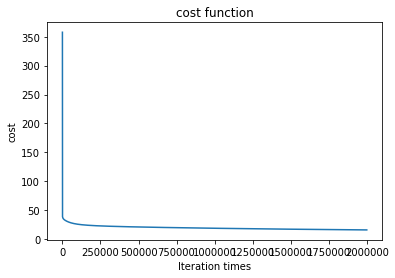

w:[[-0.07615176  0.07975529 -0.03884706  0.23694665  0.11014374  2.60056455
   0.05702427 -0.4075999   0.10887493 -0.00518834  0.29647432  0.02218629
  -0.68232766 -0.38346537]]


In [7]:
# 开始学习参数
w = LR_learn(train_X, train_Y)
print("w:" + str(w.T)) # 打印学习到的参数w

## 性能分析 - 在训练集和测试集上的表现

通过散点图, 将预测值与实际值进行对比

### 训练集

train_X, train_Y

perfomance on train data!


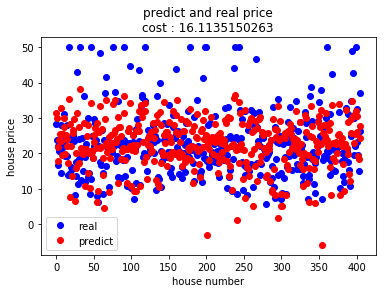

In [8]:
print("perfomance on train data!")
my_predict_show(train_X, train_Y, w)

### 测试集

test_X, test_Y

perfomance on test data!


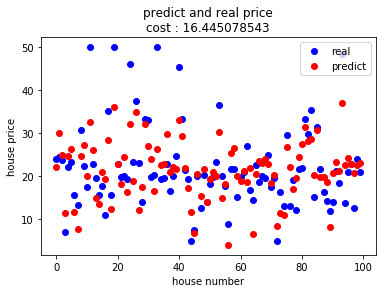

In [9]:
print("perfomance on test data!")
my_predict_show(test_X, test_Y, w)

## 总结

在
* w 的初始化 : `w = np.random.randn(13, 1) * 0.01 / np.sqrt(13)`(在函数`learn`中)
* b 的初始化 : `b = np.random.randn()`(在函数`learn`中)
* 学习率rate(在函数`LR_learn`中) : 1 * 1e-9
* 迭代次数times(在函数`LR_learn`中) : 2000000
的参数下, 

模型在训练集上的cost = 16.1135, 根据散点图来看, 除少数数据没有很好拟合, 整体来看拟合程度尚可接受

在测试集上cost = 16.445, 与训练集上的cost差别不超过0.2, 说明偏差较小

但有部分(5个左右)在训练集上的房价被拟合成负数的结果, 可能是训练数据本身不完整, 或者偏差较大

进一步改进的话, 可以人手工剔除dateset中偏差较大的数据, 对数据进行修正